# Value at Risk (VAR) & Conditional Value at Risk (CVAR)

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
from scipy.stats import norm

## Collect Sample Stock Data

In [118]:
# Define start and end date
start_date = datetime.datetime(2021, 1, 1)
end_date = datetime.datetime(2025, 1, 1)
df = yf.download(['AAPL','META', 'NVDA', 'AMZN'], start=start_date, end=end_date)['Adj Close']
df.index = pd.to_datetime(df.index)
df = df.dropna()
df.pct_change().head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,META,NVDA
Date,,,,
2021-01-04,NaN,NaN,NaN,NaN
2021-01-05,0.012364,0.010004,0.007548,0.022210
2021-01-06,-0.033662,-0.024897,-0.028269,-0.058953
2021-01-07,0.034123,0.007577,0.020622,0.057830
2021-01-08,0.008632,0.006496,-0.004354,-0.005040


## Time-series plot

Text(0.5, 1.0, 'Adjusted Close Price for Sample Stock Tickers')

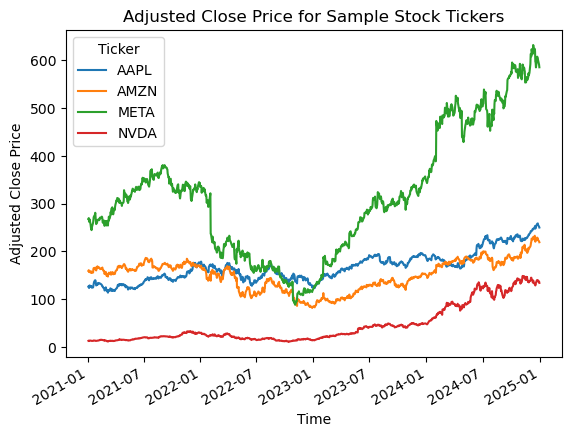

In [121]:
ax = df.plot.line(xlabel="Time", ylabel="Adjusted Close Price")
ax.set_title("Adjusted Close Price for Sample Stock Tickers")

## AAPL Percentage Change Histogram

Text(0.5, 1.0, 'Apple Percentage Change Histogram')

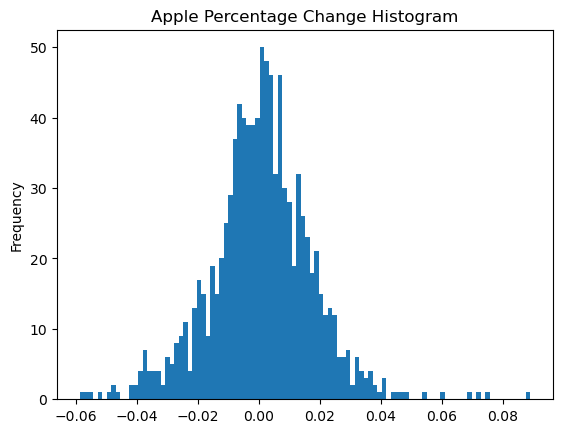

In [124]:
ax = df['AAPL'].pct_change().plot(bins=100, kind='hist')
ax.set_title("Apple Percentage Change Histogram")

In [126]:
# Obtain percentage change per stock
returns = df.pct_change().dropna()

# Calculate the portfolio returns as the weighted average of the individual asset returns
weights = np.full((4), 0.25) # assuming equal weight
port_returns = (weights * returns).sum(axis=1) # weighted sum

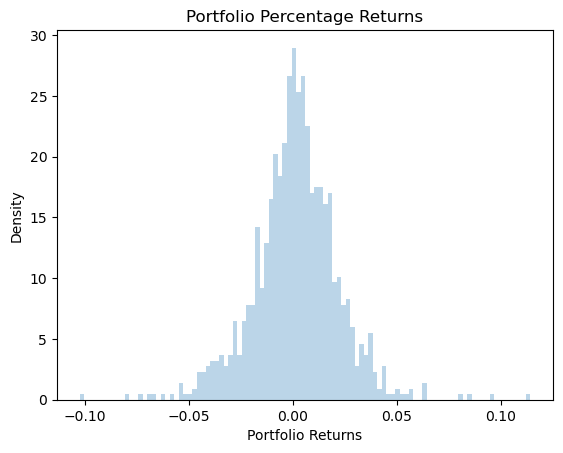

In [128]:
plt.hist(port_returns, bins=100, density=True, alpha=0.3)
plt.xlabel("Portfolio Returns")
plt.ylabel("Density")
plt.title(f"Portfolio Percentage Returns")
plt.show()

## 1. Historical Method

* The past is representative of future return patterns (i.e., the empirical return distribution remains stable over time).
* No strict parametric form (e.g., no normality assumption)—it just uses the historical distribution as-is.

In [152]:
# Assume initial portfolio value
initial_portfolio_value = 100000

# Obtain percentage change per stock
returns = df.pct_change()

# Calculate the portfolio returns as the weighted average of the individual asset returns
weights = np.full(shape=4, fill_value=0.25)  # assuming equal weights
portfolio_returns = (weights * returns).sum(axis=1)  # weighted sum

# Set confidence level
confidence_level = 0.95
alpha = 1 - confidence_level

# Calculate Historical VaR (in return space)
VaR_level = portfolio_returns.quantile(q=alpha)

# Calculate Historical CVaR (Expected Shortfall) in return space
CVaR_level = portfolio_returns[portfolio_returns <= VaR_level].mean()

# Convert these return-based metrics into monetary amounts
VaR_amount = VaR_level * initial_portfolio_value
CVaR_amount = CVaR_level * initial_portfolio_value

print(f"Historical VaR at {confidence_level:.0%} confidence: {VaR_amount:,.2f} ({VaR_level:.2%})")
print(f"Historical CVaR at {confidence_level:.0%} confidence: {CVaR_amount:,.2f} ({CVaR_level:.2%})")

Historical VaR at 95% confidence: -3,351.45 (-3.35%)
Historical CVaR at 95% confidence: -4,539.89 (-4.54%)


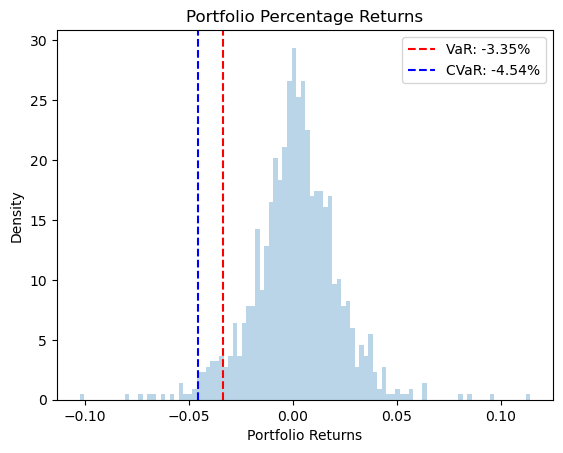

In [154]:
# Plot histogram of portfolio returns
plt.hist(portfolio_returns, bins=100, density=True, alpha=0.3)

# Add VaR and CVaR lines
plt.axvline(x=VaR_level, color='red', linestyle='--', label=f"VaR: {VaR_level:.2%}")
plt.axvline(x=CVaR_level, color='blue', linestyle='--', label=f"CVaR: {CVaR_level:.2%}")

# Add legend and labels
plt.legend()
plt.xlabel("Portfolio Returns")
plt.ylabel("Density")
plt.title("Portfolio Percentage Returns")

# Show the plot
plt.show()

## 2. Parametric Method (Variance-Covariance)

* Returns follow a **normal distribution**.
* The portfolio’s mean and variance fully describe its distribution.
* Daily returns are independent, identically distributed (i.i.d.) under that normal assumption.

In [158]:
# 1. Assume initial portfolio value
initial_portfolio_value = 100000

# 2. Obtain percentage change per stock
asset_returns = df.pct_change()

# 3. Calculate mean and covariance matrix of returns
asset_mean_returns = asset_returns.mean()
asset_cov_matrix = asset_returns.cov()

# 4. Calculate portfolio mean return and standard deviation
weights = np.full(shape=4, fill_value=0.25)  # equal weights
portfolio_mean_return = (weights * asset_mean_returns).sum()
portfolio_std_dev = np.sqrt(weights.T @ asset_cov_matrix @ weights)

# 5. Calculate VaR and CVaR using the Parametric (Variance-Covariance) Method
confidence_level = 0.95
z_score = norm.ppf(1 - confidence_level)   # typically negative for 0.95

# VaR in return space
VaR_return = - (norm.ppf(confidence_level) * portfolio_std_dev - portfolio_mean_return)

# CVaR (Expected Shortfall) in return space
CVaR_return = portfolio_mean_return - portfolio_std_dev * (
    norm.pdf(z_score) / (1 - confidence_level)
)

# 6. Convert VaR and CVaR (returns) into monetary amounts
VaR_amount = VaR_return * initial_portfolio_value
CVaR_amount = CVaR_return * initial_portfolio_value

# 7. Print results
print(f"Parametric VaR at {confidence_level:.0%} confidence level: {VaR_amount:.2f} ({VaR_return:.2%})")
print(f"Parametric CVaR at {confidence_level:.0%} confidence level: {CVaR_amount:.2f} ({CVaR_return:.2%})")

Parametric VaR at 95% confidence level: -3218.09 (-3.22%)
Parametric CVaR at 95% confidence level: -4070.14 (-4.07%)


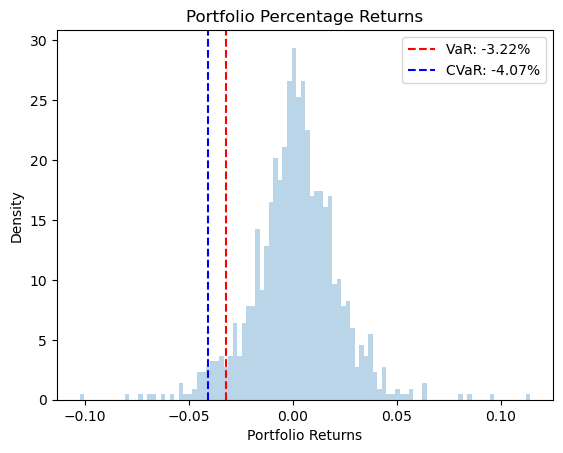

In [160]:
# Plot the histogram of portfolio returns
plt.hist(portfolio_returns, bins=100, density=True, alpha=0.3)

# Add VaR and CVaR lines (in return space)
plt.axvline(x=VaR_return, color='red', linestyle='--', label=f"VaR: {VaR_return:.2%}")
plt.axvline(x=CVaR_return, color='blue', linestyle='--', label=f"CVaR: {CVaR_return:.2%}")

# Add legend and labels
plt.legend()
plt.xlabel("Portfolio Returns")
plt.ylabel("Density")
plt.title("Portfolio Percentage Returns")
plt.show()

## 3. Monte Carlo Simulation

* Similar to the parametric method’s assumption: daily returns come from a multivariate normal with the historically estimated mean vector and covariance matrix.
* Correlations between stocks are assumed to remain stable and are fully captured by the covariance matrix.
* Each day is simulated independently under the same distribution.

In [164]:
# 1. Set random seed for reproducibility
np.random.seed(123)

# 2. Define the initial portfolio value
initial_portfolio_value = 100000

# 3. Define simulation parameters
n_simulations = 400       # number of simulations
n_days = 252              # number of trading days in a year
portfolio_weights = np.full(shape=4, fill_value=0.25)

# 4. Create a matrix of mean returns for each day and each stock
daily_mean_matrix = np.full(
    shape=(n_days, len(portfolio_weights)),
    fill_value=asset_mean_returns  # rename mean_returns to asset_mean_returns if needed
).T

# 5. Prepare an array to store simulated daily percentage changes
simulated_pct_changes = np.full(
    shape=(n_days, n_simulations),
    fill_value=0.0
)

# 6. Run the Monte Carlo simulation
for sim_index in range(n_simulations):
    # Generate random draws for each trading day and each asset
    random_draws = np.random.normal(size=(n_days, len(portfolio_weights)))
    
    # Obtain the Cholesky decomposition of the covariance matrix
    L = np.linalg.cholesky(asset_cov_matrix)  # rename cov_matrix to asset_cov_matrix if needed
    
    # Calculate daily percentage change using the Cholesky decomposition
    daily_pct_change = daily_mean_matrix + np.inner(L, random_draws)
    
    # Calculate the simulated portfolio percentage change for each day
    simulated_pct_changes[:, sim_index] = np.inner(portfolio_weights, daily_pct_change.T)

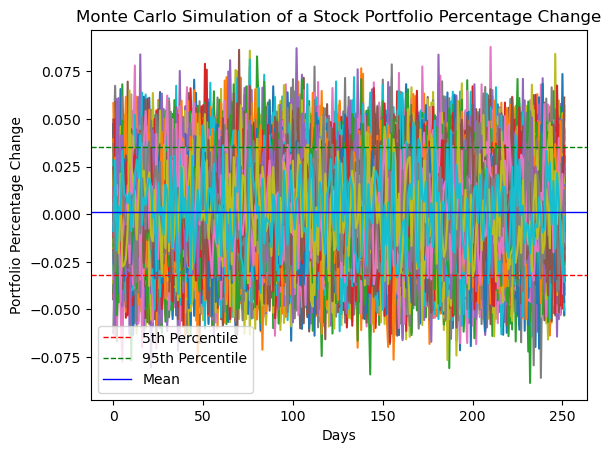

In [166]:
# Plot each simulation's daily percentage change
plt.plot(simulated_pct_changes)

# Add horizontal lines for the 5th percentile, 95th percentile, and mean
plt.axhline(
    np.percentile(simulated_pct_changes, 5),
    color='r',
    linestyle='dashed',
    linewidth=1,
    label='5th Percentile'
)
plt.axhline(
    np.percentile(simulated_pct_changes, 95),
    color='g',
    linestyle='dashed',
    linewidth=1,
    label='95th Percentile'
)
plt.axhline(
    np.mean(simulated_pct_changes),
    color='b',
    linestyle='solid',
    linewidth=1,
    label='Mean'
)

# Configure plot details
plt.legend()
plt.ylabel('Portfolio Percentage Change')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of a Stock Portfolio Percentage Change')
plt.show()

In [167]:
# 1. Set confidence level
confidence_level = 0.95
alpha = 1 - confidence_level

# 2. Extract the final day’s *percentage returns* from all simulations
final_day_pct_changes = pd.Series(simulated_pct_changes[-1, :])

# 3. Calculate the VaR and CVaR in *return* (percentage) terms
mc_VaR_return = final_day_pct_changes.quantile(q=alpha)
mc_CVaR_return = final_day_pct_changes[final_day_pct_changes <= mc_VaR_return].mean()

# 4. Convert simulated percentage changes into simulated *portfolio values*
simulated_portfolio_values = np.full(
    shape=(n_days, n_simulations),
    fill_value=0.0
)

for sim_index in range(n_simulations):
    # cumulative product of (1 + daily_return) to get growth factor, then multiply by initial capital
    simulated_portfolio_values[:, sim_index] = (
        np.cumprod(simulated_pct_changes[:, sim_index] + 1) * initial_portfolio_value
    )

# 5. Select the *final-day portfolio values* across all simulations
final_portfolio_values = simulated_portfolio_values[-1, :]

# 6. Compute VaR and CVaR in *monetary* terms from final portfolio values
mc_VaR_value = np.percentile(final_portfolio_values, 5)  # 5th percentile
mc_CVaR_value = final_portfolio_values[final_portfolio_values <= mc_VaR_value].mean()

# 7. Print results
print(f"Monte Carlo VaR at {confidence_level:.0%} confidence level: ${mc_VaR_value:,.2f} ({mc_VaR_return:.2%})")
print(f"Monte Carlo CVaR at {confidence_level:.0%} confidence level: ${mc_CVaR_value:,.2f} ({mc_CVaR_return:.2%})")

Monte Carlo VaR at 95% confidence level: $79,600.41 (-3.45%)
Monte Carlo CVaR at 95% confidence level: $66,860.52 (-4.05%)


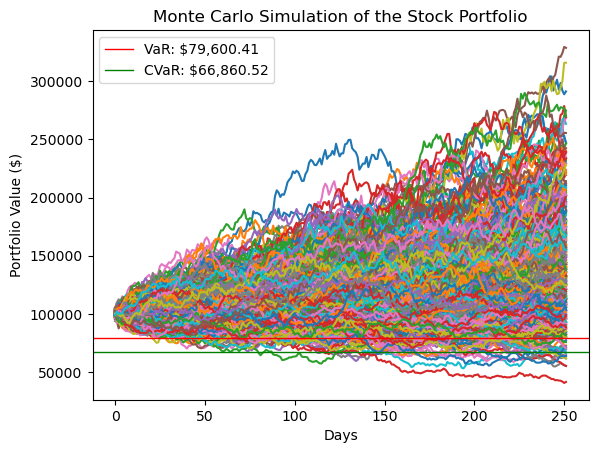

In [168]:
# Plot the simulated portfolio values for each simulation
plt.plot(simulated_portfolio_values)

# Add horizontal lines for VaR and CVaR in monetary terms
plt.axhline(
    mc_VaR_value,
    color='r',
    linewidth=1,
    label=f'VaR: ${mc_VaR_value:,.2f}'
)
plt.axhline(
    mc_CVaR_value,
    color='g',
    linewidth=1,
    label=f'CVaR: ${mc_CVaR_value:,.2f}'
)

plt.legend(loc='upper left')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of the Stock Portfolio')
plt.show()